In [277]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.metrics import precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from yellowbrick.regressor import CooksDistance
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt 
from statsmodels.api import OLS
import seaborn as sns 
import pandas as pd 
import numpy as np 
sns.set_style(style='darkgrid')
import warnings 
warnings.filterwarnings('ignore')

In [278]:
# load dataset 
with open('bank-full.csv','r') as file:
    bank = []
    data = file.readlines()
    column = [x.replace('"','')for x in data[0].split(';')]
    for line in data[1:]:
        bank.append([x.replace('"','') for x in line.split(';')])
    data = pd.DataFrame(bank,columns=column)
    file.close()
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y\n
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no\n
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no\n
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no\n
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no\n
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no\n


In [279]:
# dataset contains 45211 observations 
# and 17 columns
data.shape

(45211, 17)

In [280]:
# there are no null values present 
pd.DataFrame(data.isnull().sum()).rename(columns={0:'Null Count'})

,Null Count
age,0
job,0
marital,0
education,0
default,0
balance,0
housing,0
loan,0
contact,0
day,0


In [281]:
# all the columns have categorial data
# need to convert them into numerical type 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  object
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  object
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  object
 10  month      45211 non-null  object
 11  duration   45211 non-null  object
 12  campaign   45211 non-null  object
 13  pdays      45211 non-null  object
 14  previous   45211 non-null  object
 15  poutcome   45211 non-null  object
 16  y
         45211 non-null  object
dtypes: object(17)
memory usage: 5.9+ MB


In [282]:
# changing dypes of ['age','balance','day','duration','campaign','pdays','previous'] to int
data[['age','balance','day','duration','campaign','pdays','previous']] = data[['age','balance','day','duration','campaign','pdays','previous']].astype('int')

In [283]:
# changed dtype of ['age','balance','campaign','pdays','previous'] to int
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int32 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int32 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int32 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int32 
 12  campaign   45211 non-null  int32 
 13  pdays      45211 non-null  int32 
 14  previous   45211 non-null  int32 
 15  poutcome   45211 non-null  object
 16  y
         45211 non-null  object
dtypes: int32(7), object(10)
memory usage: 4.7+ MB


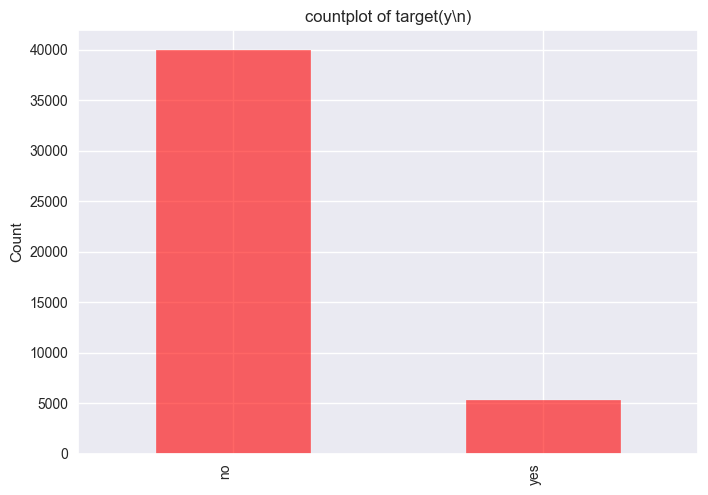

In [284]:
# countplot of target (y/n)
data['y\n'].value_counts().plot(kind='bar',
                           color='red',
                           alpha=0.6)
plt.ylabel('Count')
plt.title('countplot of target(y\\n)')
plt.show()

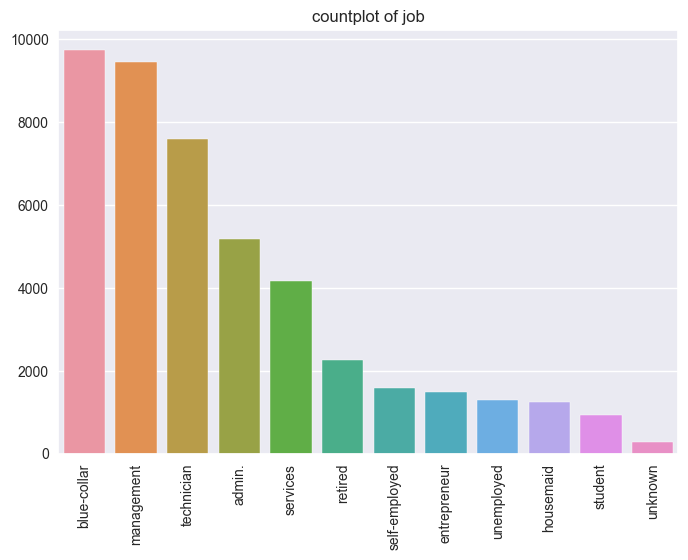

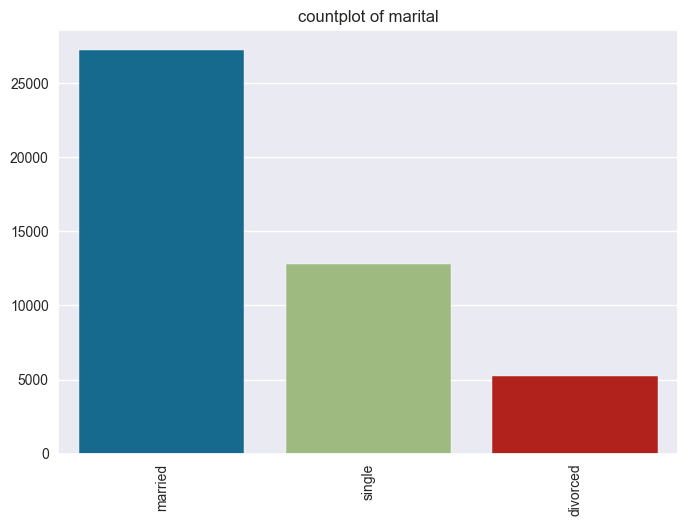

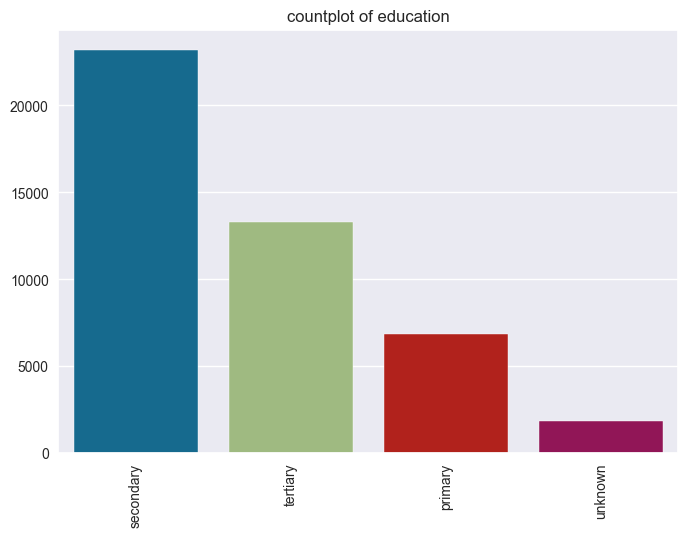

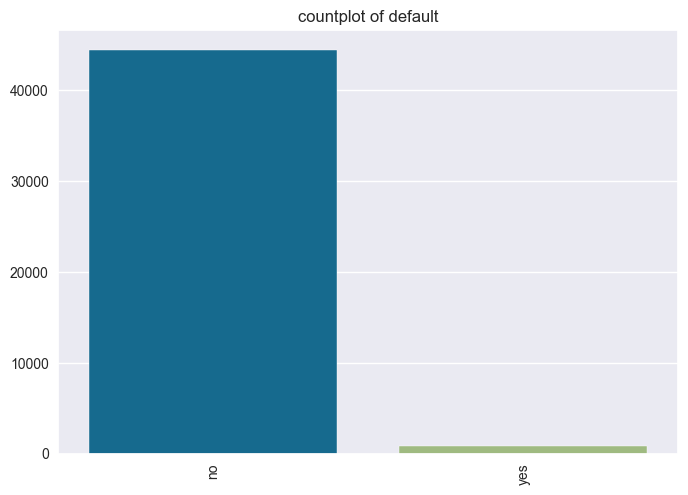

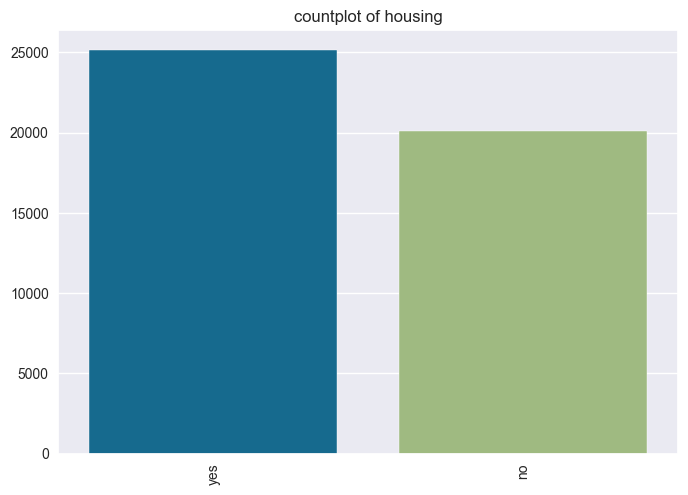

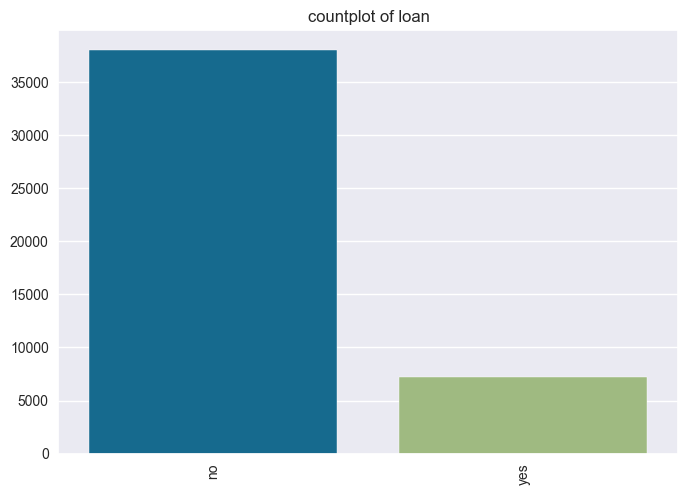

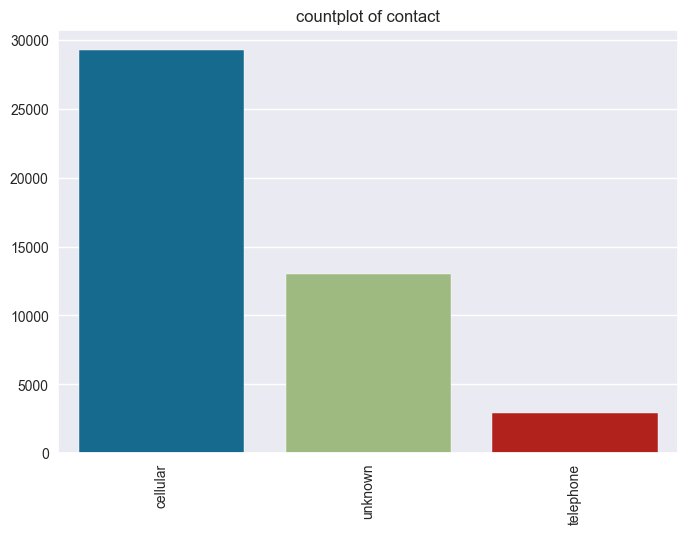

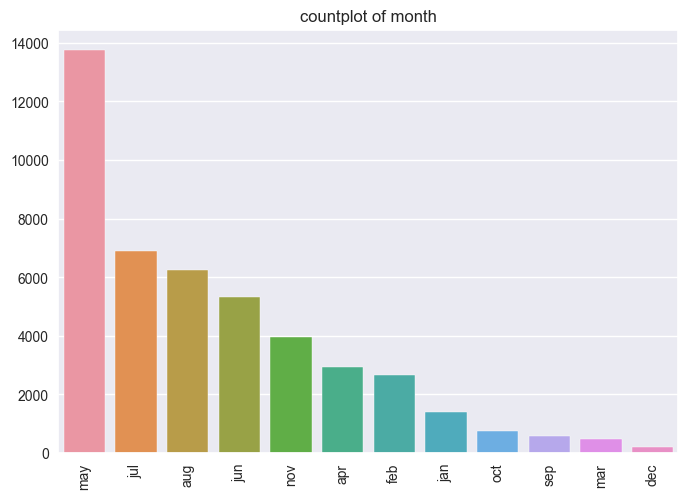

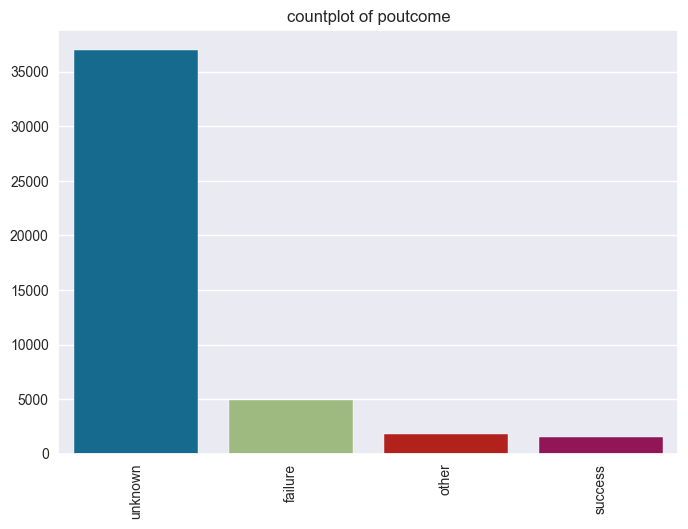

In [285]:
# countplots of features
column = [col for col in data.columns if data[col].dtypes == 'object'][:-1]
for col in column:
    count = data[col].value_counts()
    sns.barplot(x=count.index,y=count.values)
    plt.title('countplot of '+col)
    plt.xticks(rotation=90)
    plt.show()

In [286]:
# segregating dataset into feature and target(y\n)
X = data.iloc[:,data.columns != 'y\n']   # features
Y = data[['y\n']]                        # target

In [287]:
X.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown


In [288]:
Y.head()

,y\n
0,no\n
1,no\n
2,no\n
3,no\n
4,no\n


In [289]:
# label encoding of target data
enc = LabelEncoder()
newY = Y.copy(deep=True)
newY['y\n'] = enc.fit_transform(Y.values.ravel())
newY.head()

,y\n
0,0
1,0
2,0
3,0
4,0


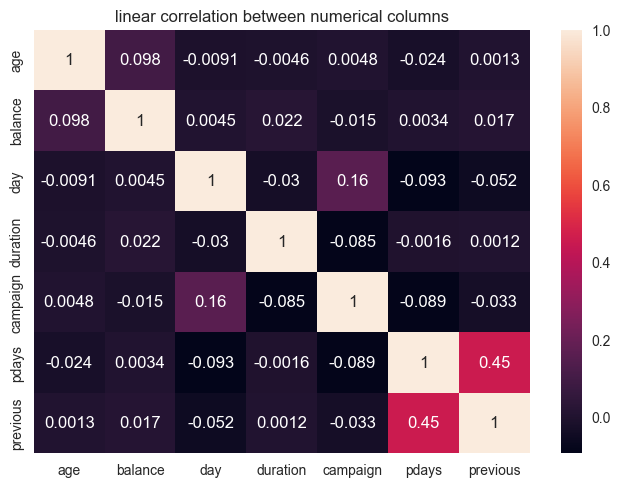

In [290]:
# linear correlation between numerical columns
sns.heatmap(X[[col for col in X.columns if X[col].dtypes != 'object']].corr(),annot=True)
plt.title('linear correlation between numerical columns')
plt.show()

In [291]:
pd.get_dummies(X.job,prefix='job')

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown
0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
45206,0,0,0,0,0,0,0,0,0,1,0,0
45207,0,0,0,0,0,1,0,0,0,0,0,0
45208,0,0,0,0,0,1,0,0,0,0,0,0
45209,0,1,0,0,0,0,0,0,0,0,0,0


In [292]:
newX = X[[col for col in X.columns if X[col].dtypes != 'object']].copy(deep=True)
column = [col for col in X.columns if X[col].dtypes == 'object']
for col in column:
    en = pd.get_dummies(X[[col]],prefix=col)
    drCol = en.columns[-1]
    newX = newX.join(en.iloc[:,:-1])

In [293]:
newX.head()

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,poutcome_failure,poutcome_other,poutcome_success
0,58,2143,5,261,1,-1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,44,29,5,151,1,-1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,33,2,5,76,1,-1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
3,47,1506,5,92,1,-1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
4,33,1,5,198,1,-1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [294]:
newData = newY.join(newX)
newData.head()

,y\n,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,...,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,poutcome_failure,poutcome_other,poutcome_success
0,0,58,2143,5,261,1,-1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,44,29,5,151,1,-1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,33,2,5,76,1,-1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,47,1506,5,92,1,-1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,33,1,5,198,1,-1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [295]:
# logistic regression model 
model = LogisticRegression()

In [296]:
model.fit(newX.values,newY.values.ravel())

LogisticRegression()

In [297]:
n = precision_recall_fscore_support(newY.values.ravel(),y_pred,average='weighted')[:2]
pd.DataFrame([['Precision',n[0]],
              ['Recall',n[-1]]],columns=['Score','Values'])

,Score,Values
0,Precision,0.868046
1,Recall,0.891133


In [298]:
# detecting and reducing multicollinearty with VIF
# by dropping correlated features
multColDF = []
c = []
for i in range(10):
    # remove feature with highest VIF in each iteration
    # and store dataframe in 'df'
    df = newX.loc[:,[(i not in c) for i in newX.columns]]
    # calculating VIF of each feature 
    # after dropping feature with highest VIF
    multCol = pd.DataFrame([[df.columns[i],vif(df,i)]for i in range(len(df.columns))],
                           columns=['Feature','VIF'])
    multColDF.append(multCol)
    # stop iteration if VIF of feature is greater than 10
    if multCol.VIF.iloc[multCol.VIF.idxmax(axis=0)] > 10:
        c.append(multCol.Feature.iloc[multCol.VIF.idxmax(axis=0)])
    else:
        break

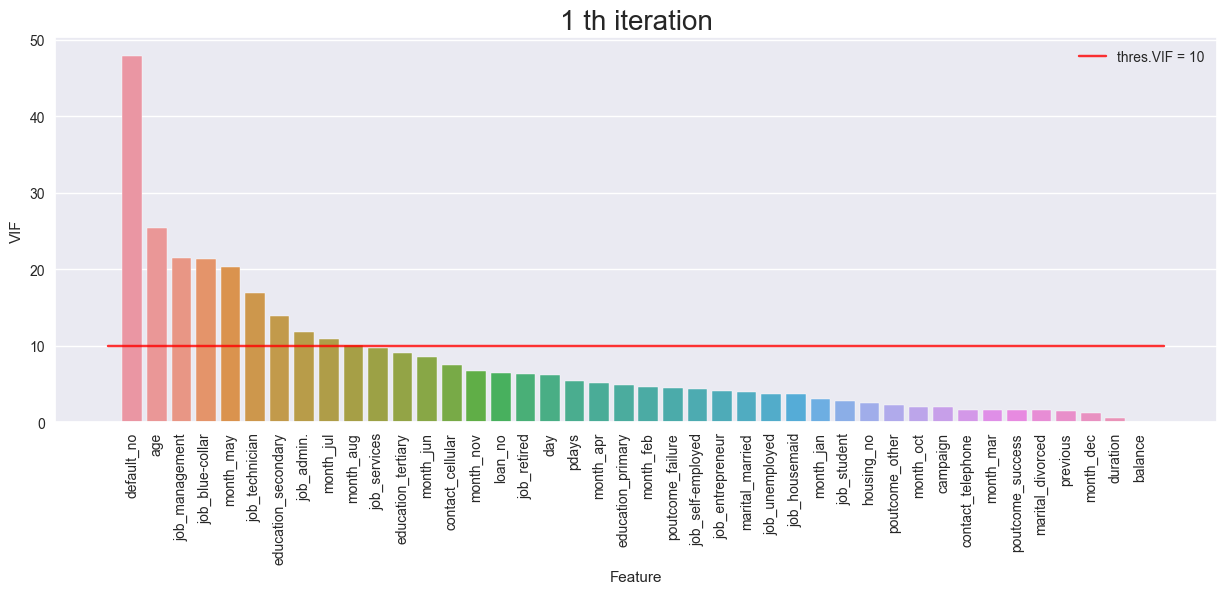

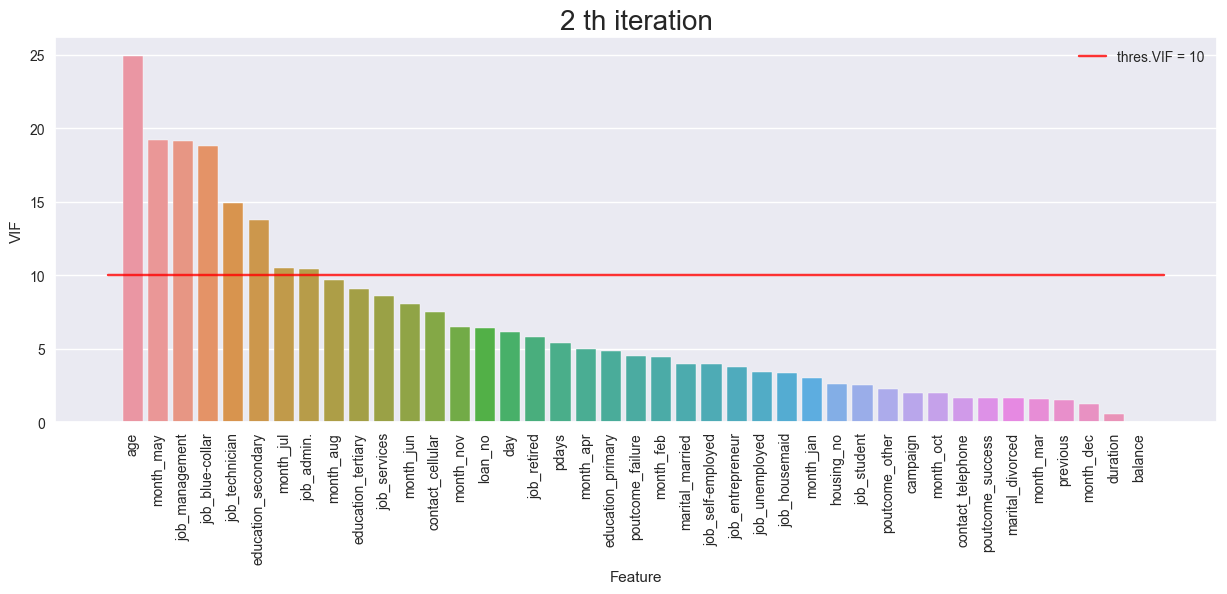

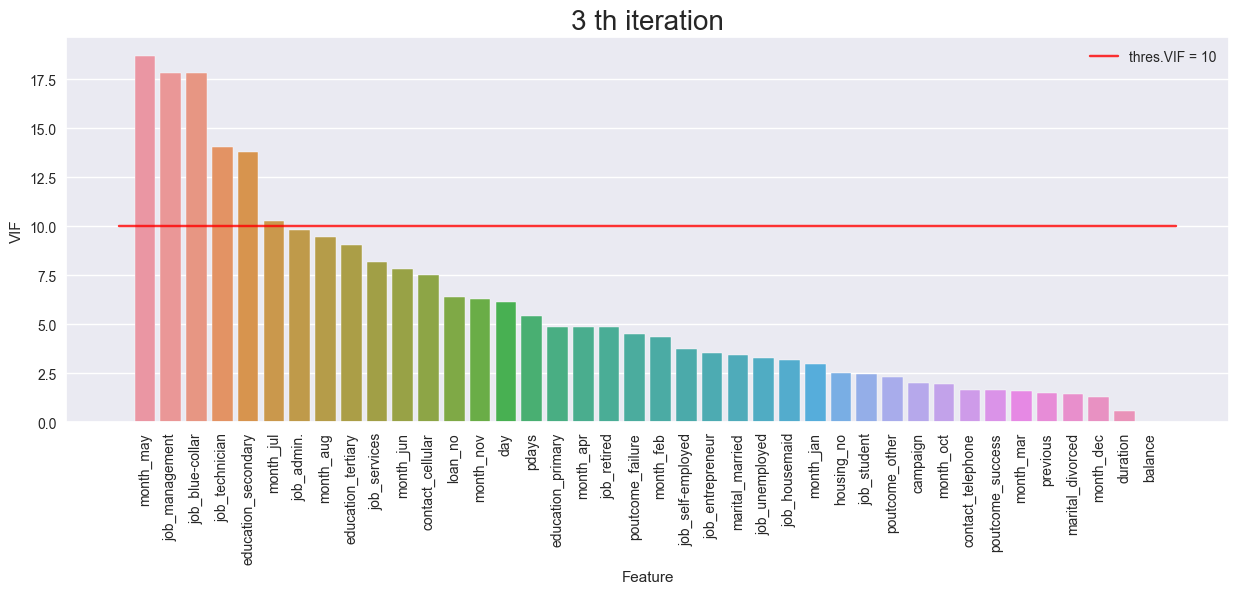

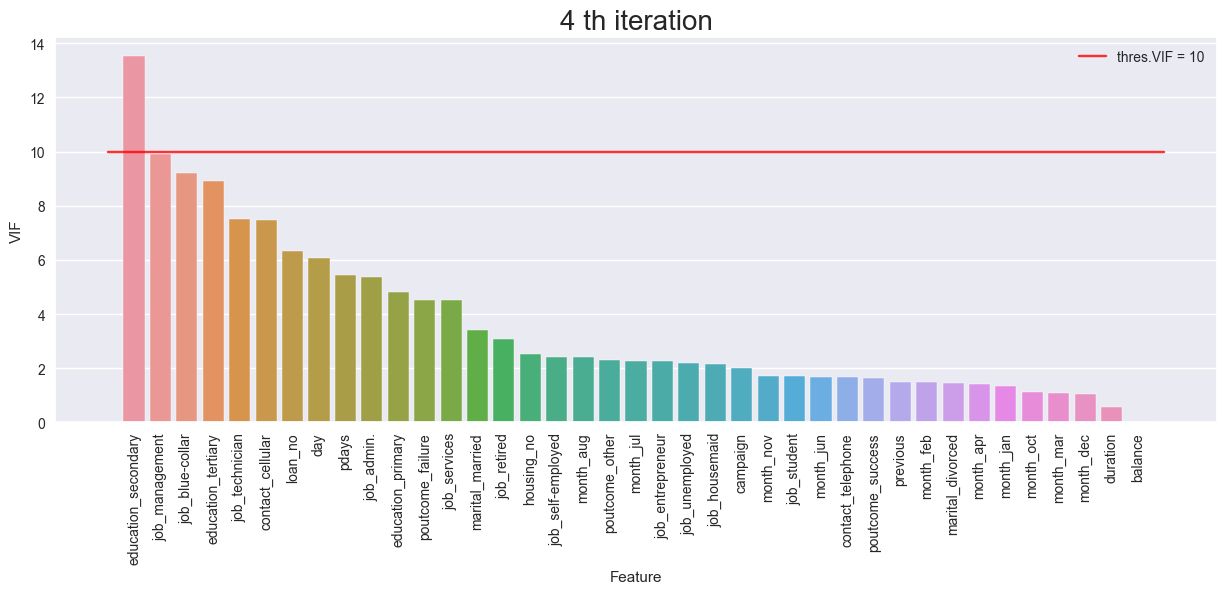

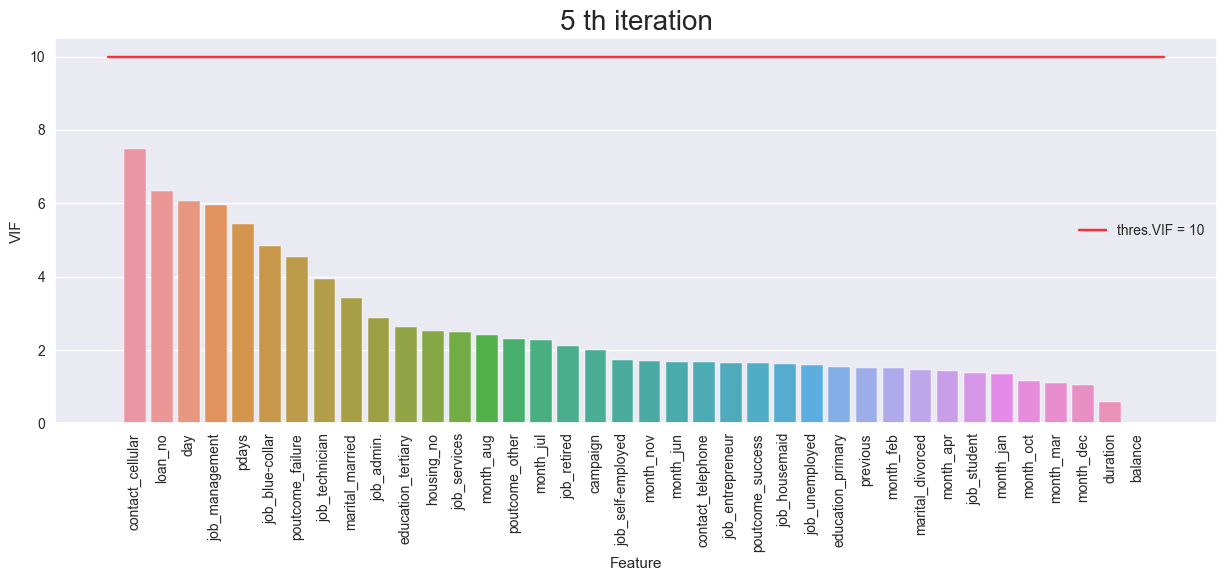

In [299]:
for i in range(len(multColDF)):
    y = multColDF[i].sort_values(by=['VIF'],ascending=False)
    plt.figure(figsize=(15,5))
    sns.barplot(x=y.Feature,
                y=y.VIF)
    plt.plot([-1,len(y)],[10,10],
             color='red',
             marker='+',
             alpha=0.8,
             label='thres.VIF = 10')
    plt.title(f'{i+1} th iteration',
              fontsize=20)
    plt.legend()
    plt.xticks(rotation=90)
    plt.show()

In [300]:
# feature without multicollinearity 
multColDF[-1][['Feature']]

,Feature
0,balance
1,day
2,duration
3,campaign
4,pdays
5,previous
6,job_admin.
7,job_blue-collar
8,job_entrepreneur
9,job_housemaid


In [301]:
# new model without multicollinearity
newModelData = newX[multColDF[-1].Feature.values]
newModel = LogisticRegression()
newModel.fit(newModelData.values,newY.values.ravel())

LogisticRegression()

### newModel accuracy score after reducing multicollinearity is 89.1137 % 

In [302]:
newModel.score(newModelData.values,newY.values.ravel())

0.8911326889473801

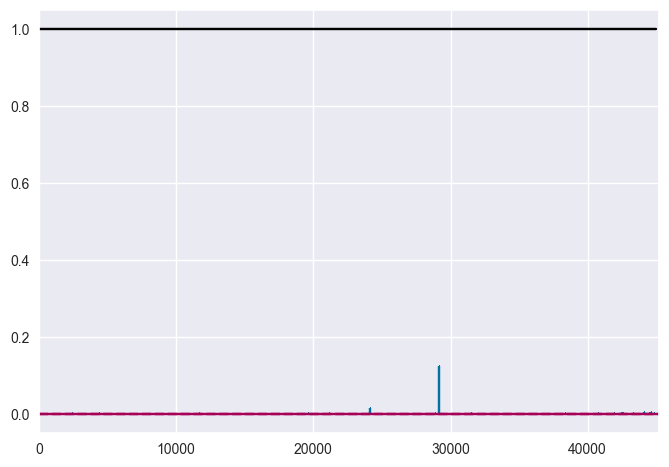

In [303]:
# No influential points present 
c = CooksDistance()
c.fit(newModelData.values,newY.values.ravel())
plt.plot([0,45000],[1,1],
         color='black')
plt.show()

### no influential data points present 

In [304]:
len(newModel.coef_[0])

38

In [305]:
len(multColDF[-1].Feature.values)

38

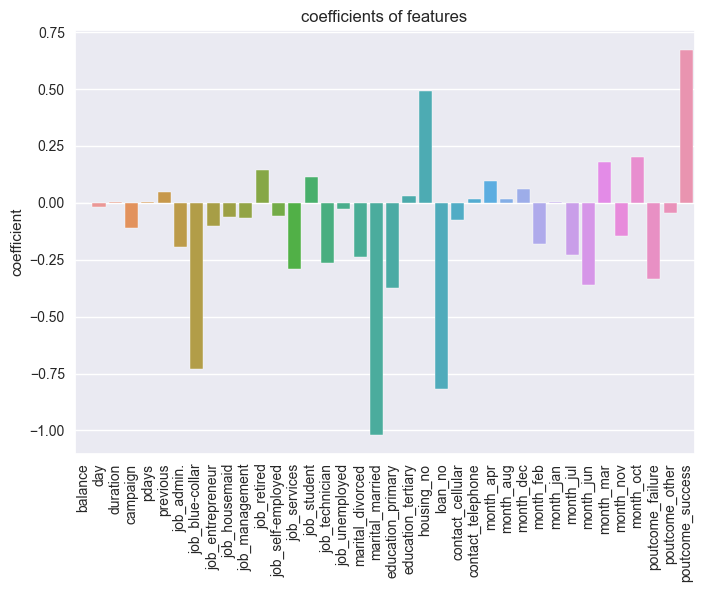

In [306]:
sns.barplot(x=multColDF[-1].Feature.values,
        y=newModel.coef_[0])
plt.ylabel('coefficient')
plt.xticks(rotation=90)
plt.title('coefficients of features')
plt.show()

In [307]:
y_pred = newModel.predict(newModelData)

In [308]:
y_pred_df = pd.DataFrame({'Actual':newY.values.ravel(),
                          'Predicted':y_pred})
y_pred_df

,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
45206,1,0
45207,1,0
45208,1,1
45209,0,0


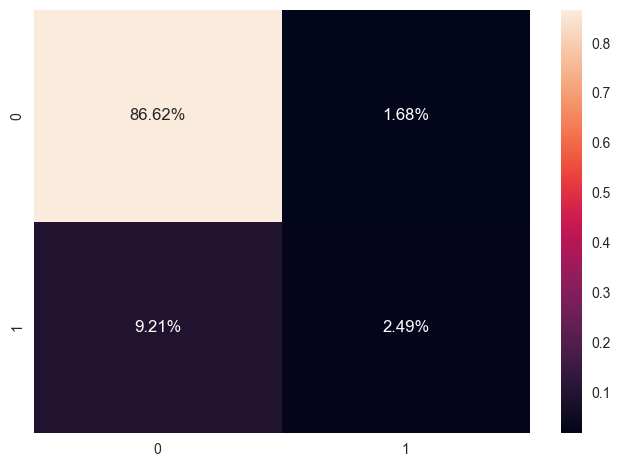

In [309]:
# confusion matrix
confusion = confusion_matrix(newY.values.ravel(),
                             y_pred)
sns.heatmap(confusion/confusion.sum(),
            annot=True,
           fmt= '.2%')
plt.show()

In [310]:
print('CLASSIFICATION REPORT ->\n')
print(classification_report(newY.values.ravel(),
                      y_pred))

CLASSIFICATION REPORT ->

              precision    recall  f1-score   support

           0       0.90      0.98      0.94     39922
           1       0.60      0.21      0.31      5289

    accuracy                           0.89     45211
   macro avg       0.75      0.60      0.63     45211
weighted avg       0.87      0.89      0.87     45211



In [311]:
fpr, tpr, thresh = roc_curve(newY.values.ravel(),
                             newModel.predict_proba(newModelData.values)[:,1])
auc = roc_auc_score(newY.values.ravel(),
                    y_pred)

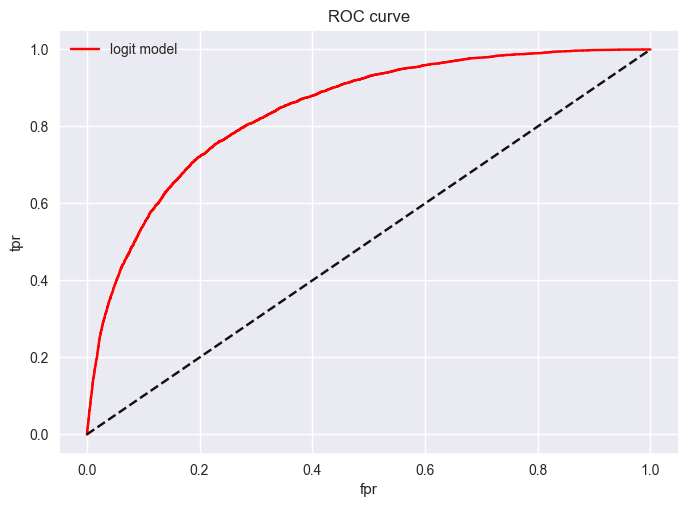

In [312]:
plt.plot(fpr,tpr,color='red',label='logit model')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.plot([0,1],[0,1],'k--')
plt.title('ROC curve')
plt.legend()
plt.show()

In [313]:
print(f'Area Under Curve is {auc}')

Area Under Curve is 0.596859295365043


In [314]:
newModel.score(newModelData.values,newY.values.ravel())
y_pred_df = pd.DataFrame({'Actual':newY.values.ravel(),
                          'Predicted':y_pred})
y_pred_df

,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
45206,1,0
45207,1,0
45208,1,1
45209,0,0


In [315]:
n = precision_recall_fscore_support(newY.values.ravel(),y_pred,average='weighted')[:2]
pd.DataFrame([['Precision',n[0]],
              ['Recall',n[-1]]],columns=['Score','Values'])

,Score,Values
0,Precision,0.868046
1,Recall,0.891133


# Built Logistic Regression Model to predict whether client has subscribed a term deposit or not with Precision of 86.80% and Recall of 89.11%